In [1]:
import pandas as pd # Data analysis and manipultion tool
import numpy as np # Fundamental package for linear algebra and multidimensional arrays
import tensorflow as tf # Deep Learning Tool
import os # OS module in Python provides a way of using operating system dependent functionality
import cv2 # Library for image processing
from sklearn.model_selection import train_test_split # For splitting the data into train and validation set
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from imutils import build_montages
from imutils import paths
import random
import cv2

In [3]:
imagePaths = list(paths.list_images("G:\PYTHON\Final year project\Final\covid_image_data\covid_image_data\train"))
random.shuffle(imagePaths)
imagePaths = imagePaths[:21]

In [4]:
# initialize the list of images
images = []
# loop over the list of image paths
for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    images.append(image)
# load the image and update the list of images
# construct the montages for the images
montages = build_montages(images, (128, 196), (7, 3))

In [5]:
labels = pd.read_csv("G:\PYTHON\Final year project\Final\covid_image_data\covid_image_data\Training_set_covid.csv")

labels.head()
file_paths = [[fname, 'G:/PYTHON/Final year project/Final/covid_image_data/covid_image_data/train/' + fname] for fname in labels['filename']]

if len(labels) == len(file_paths):
    print('Number of labels i.e. ', len(labels), 'matches the number of filenames i.e. ', len(file_paths))
else:
    print('Number of labels does not match the number of filenames')

images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
images.head()


train_data = pd.merge(images, labels, how = 'inner', on = 'filename')
train_data.head()

Number of labels i.e.  3479 matches the number of filenames i.e.  3479


,filename,filepaths,label
0,Image_1.jpg,G:/PYTHON/Final year project/Final/covid_image...,1
1,Image_2.jpg,G:/PYTHON/Final year project/Final/covid_image...,0
2,Image_3.jpg,G:/PYTHON/Final year project/Final/covid_image...,0
3,Image_4.jpg,G:/PYTHON/Final year project/Final/covid_image...,0
4,Image_5.jpg,G:/PYTHON/Final year project/Final/covid_image...,0


In [9]:
test_image_order = pd.read_csv("G:\PYTHON\Final year project\Final\covid_image_data\covid_image_data\Testing_set_covid.csv")
test_image_order.head()

file_paths_test = [[fname, 'G:/PYTHON/Final year project/Final/covid_image_data/covid_image_data/test/' + fname] for fname in test_image_order['filename']]

test_images = pd.DataFrame(file_paths_test, columns=['filename', 'filepaths'])
test_images.head()

,filename,filepaths
0,Image_1.jpg,G:/PYTHON/Final year project/Final/covid_image...
1,Image_2.jpg,G:/PYTHON/Final year project/Final/covid_image...
2,Image_3.jpg,G:/PYTHON/Final year project/Final/covid_image...
3,Image_4.jpg,G:/PYTHON/Final year project/Final/covid_image...
4,Image_5.jpg,G:/PYTHON/Final year project/Final/covid_image...


In [10]:
data = []
image_size = 224
test_pixel_data = []
import matplotlib.pyplot as plt

for i in range(len(train_data)):
    img_array = plt.imread(train_data['filepaths'][i], cv2.COLOR_BGR2RGB)

    new_img_array = cv2.resize(img_array, (image_size, image_size))
    #new_img_array = cv2.GaussianBlur(new_img_array,(5,5),0)
    data.append([new_img_array, train_data['label'][i]])


In [11]:
for i in range(len(test_images)):
    img_array = cv2.imread(test_images['filepaths'][i], cv2.COLOR_BGR2RGB)
    if img_array is None:
        print('Wrong path:', test_images['filepaths'][i])
    new_img_array = cv2.resize(img_array, (image_size, image_size))
    #new_img_array = cv2.GaussianBlur(new_img_array,(5,5),0)
    test_pixel_data.append(new_img_array)

In [12]:
np.random.shuffle(data)

In [13]:
x = []
y = []

counter = 406

for image in data:
    x.append(image[0])
    y.append(image[1])

# converting x & y to numpy array as they are list
x = np.array(x)
y = np.array(y)

In [14]:
np.unique(y, return_counts=True)

(array([0, 1], dtype=int64), array([3073,  406], dtype=int64))

In [15]:
pd.Series(y).value_counts()

0    3073
1     406
dtype: int64

In [16]:
X_train, X_val, y_train, y_val = train_test_split(x,y,test_size=0.2, random_state = 42,stratify=y)

In [17]:
test_pixel_data = np.array(test_pixel_data)

test_pixel_data = test_pixel_data/255

print(X_train.shape,X_val.shape,test_pixel_data.shape)

(2783, 224, 224, 3) (696, 224, 224, 3) (870, 224, 224, 3)


In [18]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow(X_train,y_train,batch_size=8)

val_generator = val_datagen.flow(X_val,y_val,batch_size=8)

In [19]:
pd.Series(y_val).value_counts(normalize=True)

0    0.883621
1    0.116379
dtype: float64

In [20]:
print(X_train.shape,X_val.shape)

(2783, 224, 224, 3) (696, 224, 224, 3)


In [5]:
import keras.backend as K

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [21]:
cbs = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-5, verbose=0),
tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=10, verbose=1, mode='auto')]

In [22]:
from tensorflow.keras.applications import VGG16,EfficientNetB0,NASNetMobile,DenseNet201
from keras.layers import *
from keras.models import Sequential
from keras.regularizers import *
from tensorflow.keras.optimizers import Adam

In [23]:
def build_model():
    model = Sequential()

    conv_base = EfficientNetB0(input_shape=(224,224,3), include_top=False, pooling='max',weights='imagenet')
    model.add(conv_base)
    model.add(BatchNormalization())
    model.add(Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)))
    model.add(BatchNormalization())
  # model.add(Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)))
  # model.add(BatchNormalization())
  # model.add(Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)))
  # model.add(BatchNormalization())
  # model.add(Dense(1024, activation='relu', kernel_regularizer=l1_l2(0.01)))
  # model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    for layer in model.layers:
        layer.trainable = True
 
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy',"Precision","Recall"])

    return model

In [24]:
model = build_model()
model.summary()

16719872/16705208 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dense (Dense)                (None, 2048)              2623488   
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 6,688,420
Trainable params: 6,639,741
Non-trainable params: 48,679
_________________________________________________________________


C:\Users\Charan Chandra\anaconda3\envs\gputest\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [25]:
from tensorflow.python.keras.callbacks import TensorBoard
from time import time
Tensorboard = TensorBoard(log_dir="G:\\PYTHON\\Final year project\\Final\\covid_image_data\\covid_image_data\\weights\\{}".format(time()))

In [26]:
%%timeit -n1 -r1 
with tf.device("GPU"):
    model.fit(train_generator,steps_per_epoch=87,epochs=100,validation_data=val_generator,validation_steps=22,callbacks=[cbs,Tensorboard],class_weight={0:1,1:2})

C:\Users\Charan Chandra\anaconda3\envs\gputest\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/100
87/87 [==============================] - 55s 334ms/step - loss: 485.8745 - accuracy: 0.6662 - precision: 0.2733 - recall: 0.8542 - val_loss: 400.4271 - val_accuracy: 0.1023 - val_precision: 0.1023 - val_recall: 1.0000
Epoch 2/100
87/87 [==============================] - 22s 256ms/step - loss: 327.4297 - accuracy: 0.7342 - precision: 0.2899 - recall: 0.8118 - val_loss: 259.7607 - val_accuracy: 0.8807 - val_precision: 1.0000 - val_recall: 0.0455
Epoch 3/100
87/87 [==============================] - 22s 250ms/step - loss: 205.6646 - accuracy: 0.8075 - precision: 0.3542 - recall: 0.8718 - val_loss: 156.7112 - val_accuracy: 0.1989 - val_precision: 0.0940 - val_recall: 0.7000
Epoch 4/100
87/87 [==============================] - 22s 252ms/step - loss: 119.4129 - accuracy: 0.8190 - precision: 0.3850 - recall: 0.8675 - val_loss: 87.7515 - val_accuracy: 0.8409 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/100
87/87 [==============================] - 21s 247ms/step - los

Epoch 37/100
87/87 [==============================] - 23s 259ms/step - loss: 0.5324 - accuracy: 0.9440 - precision: 0.7089 - recall: 0.7778 - val_loss: 4.9335 - val_accuracy: 0.1136 - val_precision: 0.1136 - val_recall: 1.0000
Epoch 38/100
87/87 [==============================] - 23s 263ms/step - loss: 0.5009 - accuracy: 0.9468 - precision: 0.7347 - recall: 0.8675 - val_loss: 0.6459 - val_accuracy: 0.8409 - val_precision: 0.4615 - val_recall: 0.7200
Epoch 39/100
87/87 [==============================] - 23s 263ms/step - loss: 0.5077 - accuracy: 0.9497 - precision: 0.7396 - recall: 0.8765 - val_loss: 0.5465 - val_accuracy: 0.9148 - val_precision: 0.6667 - val_recall: 0.6957
Epoch 40/100
87/87 [==============================] - 23s 266ms/step - loss: 0.5064 - accuracy: 0.9440 - precision: 0.7368 - recall: 0.8333 - val_loss: 0.7163 - val_accuracy: 0.8182 - val_precision: 0.4400 - val_recall: 0.3793
Epoch 41/100
87/87 [==============================] - 23s 262ms/step - loss: 0.4549 - accura

In [136]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'


'1'

In [31]:
model.save("G:\\PYTHON\\Final year project\\Final\\covid_image_data\\covid_image_data\\efficientnetb0.h5")

C:\Users\Charan Chandra\anaconda3\envs\gputest\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [27]:
preds = model.predict(X_val/255.0)
predictions = []
for i in preds:
    if i[0] > 0.5:
        predictions.append(1)
    else:
        predictions.append(0)

In [28]:
from sklearn.metrics import f1_score,confusion_matrix
print(f1_score(y_val,predictions))
print(confusion_matrix(y_val,predictions))

0.6493506493506493
[[540  75]
 [  6  75]]


In [29]:
from sklearn.metrics import confusion_matrix,classification_report
target_names = ["COVID","Normal"]
print(classification_report(y_val,predictions, target_names=target_names))

              precision    recall  f1-score   support

       COVID       0.99      0.88      0.93       615
      Normal       0.50      0.93      0.65        81

    accuracy                           0.88       696
   macro avg       0.74      0.90      0.79       696
weighted avg       0.93      0.88      0.90       696



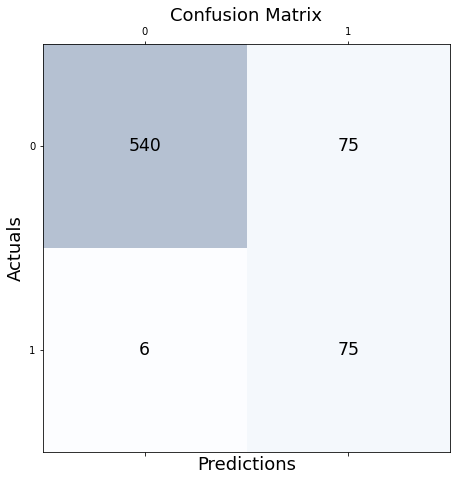

In [30]:
conf_matrix = confusion_matrix(y_val,predictions)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [21]:
predictions = []
for i in preds:
    if i[0] > 0.8:
        predictions.append(1)
    else:
        predictions.append(0)

In [51]:
pd.Series(predictions).value_counts()

0    837
1     33
dtype: int64

In [53]:
result = pd.DataFrame(predictions,columns=['prediction'])

result.value_counts()

prediction
0             837
1              33
dtype: int64

In [1]:
from keras.models import load_model
model = load_model("G:\\PYTHON\\Final year project\\Final\\covid_image_data\\covid_image_data\\vgg_16_1.h5",
                  )

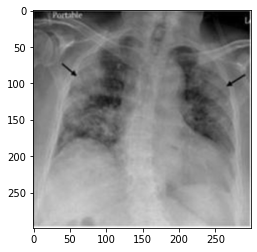

COVID


In [2]:
%matplotlib inline
# get sample image to test.
import numpy as np
import cv2
import matplotlib.pyplot as plt

img_covid = 'G:\\PYTHON\\Final year project\\Dataset\\COVID-19_Radiography_Dataset\\COVID\\COVID-289.png'
img_normal = 'G:\\PYTHON\\Final year project\\Dataset\\COVID-19_Radiography_Dataset\\Normal\\Normal-69.png'


img_array = cv2.imread(img_covid)
plt.imshow(img_array)
#plt.imshow(image)
plt.show()
new_img_array = cv2.resize(img_array, (224, 224))
dt = []
dt.append(new_img_array)
X = np.array(dt)
X = X/255
val = model.predict(X)
#print("Confidence : ",round(val[0][0]*100,2),"%")
#print(val)
if val > 0.5:
    print("COVID")
else:
    print("NORMAL")

In [3]:
def fun(pres,rec):
    print((2*pres*rec)/(pres+rec))
fun(0.92,0.99)

0.9537172774869109
